# Шаг 0. Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, mean_squared_error, silhouette_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import r2_score, f1_score

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor

import joblib
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

# Шаг 1. Чистка лишних столбцов

На этом шаге я чищу фрейм данных от лишних столбцов, не связанных с ингредиентами, а также убираю непопулярные ингредиенты для обучения модели на более точной выборке

In [3]:
df = pd.read_csv('../data/epi_r.csv')
df.shape

(20052, 680)

In [4]:
df

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20047,Parmesan Puffs,3.125,28.0,2.0,2.0,64.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,Artichoke and Parmesan Risotto,4.375,671.0,22.0,28.0,583.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,Turkey Cream Puff Pie,4.375,563.0,31.0,38.0,652.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20050,Snapper on Angel Hair with Citrus Cream,4.375,631.0,45.0,24.0,517.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Чистка столбцов фрейма

### Фун-я создания словаря с ингредиентами и не ингредиентами

In [5]:
def get_non_ingredients_patterns():
    non_ingredient_patterns = [
        # Диетические ограничения и стили питания
        'free', 'gluten', 'dairy', 'sugar', 'low', 'high', 'reduced', 'conscious',
        'healthy', 'organic', 'paleo', 'friendly', 'vegetarian', 'vegan',
        'pescatarian', 'kosher', 'halal', 'no sugar', 'low sodium', 'fat free',

        # Способы приготовления
        'cook', 'bake', 'boil', 'fry', 'grill', 'roast', 'steam', 'broil',
        'braise', 'poach', 'sauté', 'simmer', 'marinate', 'microwave',
        'pressure cooker', 'slow cooker', 'blender', 'freeze', 'chill', 'raw',
        'no-cook', 'advance prep', 'pan-fry', 'stir-fry',

        # Стили питания
        'vegetarian', 'vegan', 'pescatarian', 'kosher', 'halal',

        # Времена года, праздники, события
        'summer', 'winter', 'spring', 'fall', 'seasonal', 'holiday',
        'christmas', 'thanksgiving', 'easter', 'birthday', 'anniversary',
        'wedding', 'halloween', 'valentine', 'new year', 'party', 'shower',
        'fourth of july', 'friendsgiving', 'super bowl',
        'birthday', 'anniversary', 'christmas', 'thanksgiving', 'easter', 'wedding',
        'halloween', 'valentine', 'new year', 'party', 'shower', 'graduation',
        'mother', 'father', 'labor day', 'bastille', 'cinco de mayo', 'diwali',
        'hanukkah', 'kwanzaa', 'lunar new year', 'mardi gras', 'oktoberfest',
        'passover', 'purim', 'ramadan', 'rosh hashanah', 'st. patrick', 'sukkot',
        'back to school', 'beverly hills', 'bon app��tit', 'cr��me de cacao', 'flaming hot summer',

        # Типы блюд и курсы
        'appetizer', 'dessert', 'main', 'side', 'snack', 'breakfast', 'lunch',
        'dinner', 'soup', 'salad', 'sauce', 'drink', 'beverage', 'cocktail',
        'dip', 'spread', 'condiment', 'hors d\'oeuvre', 'digestif', 'aperitif',

        # География и имена
        'alabama', 'alaska', 'arizona', 'atlanta', 'australia', 'boston',
        'california', 'canada', 'england', 'france', 'italy', 'japan',
        'mexico', 'texas', 'new york', 'washington', 'chicago', 'aspen',
        'beverly hills', 'brooklyn', 'dorie greenspan', 'emeril lagasse',
        'nancy silverton', 'suzanne goin', 'harpercollins',

        'alabama', 'alaska', 'arizona', 'atlanta', 'australia', 'boston', 'brooklyn',
        'bulgaria', 'california', 'cambridge', 'canada', 'chicago', 'colorado',
        'columbus', 'connecticut', 'costa mesa', 'cuba', 'dallas', 'denver',
        'dominican republic', 'egypt', 'england', 'florida', 'france', 'georgia',
        'germany', 'guam', 'haiti', 'hawaii', 'healdsburg', 'hollywood', 'houston',
        'idaho', 'illinois', 'indiana', 'iowa', 'ireland', 'israel', 'italy',
        'jamaica', 'japan', 'kansas', 'kentucky', 'lancaster', 'las vegas', 'london',
        'long beach', 'los angeles', 'louisiana', 'louisville', 'maine', 'maryland',
        'massachusetts', 'mexico', 'miami', 'michigan', 'minneapolis', 'minnesota',
        'mississippi', 'missouri', 'nebraska', 'new hampshire', 'new jersey',
        'new mexico', 'new orleans', 'new york', 'north carolina', 'ohio', 'oklahoma',
        'oregon', 'pacific palisades', 'paris', 'pasadena', 'pennsylvania', 'peru',
        'philippines', 'pittsburgh', 'portland', 'providence', 'rhode island',
        'san francisco', 'santa monica', 'seattle', 'south carolina', 'spain',
        'st. louis', 'switzerland', 'tennessee', 'texas', 'utah', 'vermont',
        'virginia', 'washington', 'west virginia', 'westwood', 'wisconsin', 'yonkers',

        # Кухонное оборудование и техники
        'blender', 'candy thermometer', 'coffee grinder', 'double boiler',
        'food processor', 'ice cream machine', 'juicer', 'mandoline', 'mixer',
        'mortar and pestle', 'pasta maker', 'pressure cooker', 'ramekin',
        'slow cooker', 'smoker', 'wok',

        # Прочие теги и категории
        'quick', 'easy', 'fast', 'slow', 'gourmet', 'gourment', 'bon appétit',
        'advance prep', 'required', 'minute', 'days of', 'week', 'month', 'year',
        'entertaining', 'family', 'comfort', 'weeknight', 'weekend', 'backyard',
        'picnic', 'buffet', 'potluck', 'tailgating', 'camping', 'back to school',
        'tested', 'improved', 'critic', 'cookbook', 'epi', 'theory', 'edible gift',
        'house cocktail', 'kitchen olympics', 'poker/game night', 'sandwich theory',
        'self', 'weelicious', 'kid-friendly', 'frankenrecipe', 'flaming hot summer',
        '"no meat', 'no problem"', 'parade', 'oscars', 'house & garden'

        # Прочие теги
        'advance prep', 'required', 'minute', 'days of', 'week', 'month', 'year',
        'quick', 'easy', 'fast', 'slow', 'gourmet', 'bon appétit', 'entertaining',
        'family', 'comfort', 'weeknight', 'weekend', 'backyard', 'picnic', 'buffet',
        'potluck', 'tailgating', 'camping', 'tested', 'improved', 'critic',
        'cookbook', 'epi', 'theory', 'edible gift', 'house cocktail', 'kitchen olympics',
        'poker/game night', 'sandwich theory', 'self', 'weelicious', '"no meat, no problem"'
    ]

    return list(set(non_ingredient_patterns))

In [6]:
def create_ingredients_dict(columns_df):  
    non_ingredient_patterns = get_non_ingredients_patterns()   
    ingredients = [] 
    non_ingredient = [] 
    
    for col in columns_df['column_name']: 
        col_lower = col.lower() 
        is_ingridient = True
    
        for pattern in non_ingredient_patterns: 
            if pattern in col_lower: 
                is_ingridient = False
                break 
        
        if is_ingridient: 
            ingredients.append(col) 
        else: 
            non_ingredient.append(col)
            
    
    return {
        'ingredients': ingredients, 
        'non_ingredient': non_ingredient, 
        'total_ingredients': len(ingredients), 
        'total_non_ingredients': len(non_ingredient) 
    }
            

### Фун-я для отбора важных фич, не являющихся ингредиентами

In [7]:
def create_important_features_dict(non_ingredients_list): 
    important_categories = [
            'vegetarian', 'vegan', 'pescatarian', 'kosher', 
            'gluten-free', 'dairy-free', 'peanut free', 'soy free', 'tree nut free',
            'no sugar added', 'sugar conscious', 'fat free', 'low sodium',
            'quick & easy', 'gourmet', 'no-cook', 'slow cooker', 'pressure cooker',
            'grill', 'bake', 'roast', 'broil', 'braise',
            'quick & easy', '3-ingredient recipes', 'advance prep required'
    ]
    
    existing_features = []
     
    for el in important_categories: 
        if el in non_ingredients_list: 
            existing_features.append(el)
    
        
    return existing_features

### Фильтруем столбцы и отбираем все ингредиенты и только важные не ингредиенты

In [8]:
columns_name_df = pd.DataFrame({'column_name': df.columns})
columns_name_df.head(10)

,column_name
0,title
1,rating
2,calories
3,protein
4,fat
5,sodium
6,#cakeweek
7,#wasteless
8,22-minute meals
9,3-ingredient recipes


In [9]:
important_column = ['title', 'rating', 'calories', 'protein', 'fat', 'sodium']

In [10]:
filtered_columns_df = columns_name_df[~columns_name_df['column_name'].isin(important_column) & ~columns_name_df['column_name'].str.startswith('#')]
filtered_columns_df.head(5)

,column_name
8,22-minute meals
9,3-ingredient recipes
10,30 days of groceries
11,advance prep required
12,alabama


In [11]:
ingredients_dict = create_ingredients_dict(filtered_columns_df)
ingredients_dict['total_non_ingredients'], ingredients_dict['total_ingredients']

(282, 390)

In [12]:
important_non_ingredient_features = create_important_features_dict(ingredients_dict['non_ingredient'])
len(important_non_ingredient_features)

23

In [13]:
# перепроверяю, что никакие ингредиенты не попали в non_ingredient фичи
for i in ingredients_dict['ingredients']:
    if i in important_non_ingredient_features:
        print(i)

### Промежуточный набор колонок:

In [14]:
temp_columns = important_column + ingredients_dict['ingredients'] + important_non_ingredient_features
len(temp_columns)

419

### Фильтруем по популярности ингредиенты

In [15]:
temp_df = df.copy()

total = len(temp_df)
ingredient_count = temp_df[ingredients_dict['ingredients']].sum(numeric_only=True)
                                           
popular_real_ingredients = ingredient_count[ingredient_count > total * 0.001].index.tolist()
len(popular_real_ingredients)

294

In [16]:
# result_columns = important_column + popular_real_ingredients + important_non_ingredient_features

In [17]:
result_columns = important_column + popular_real_ingredients

In [18]:
# temp = pd.DataFrame(popular_real_ingredients)
# temp.to_csv('../data/popular_real_ingredients.csv', index=False)

### Очищенный фрейм

In [19]:
df = temp_df[result_columns]
df.shape

(20052, 300)

# Шаг 2. Анализ данных  

### Фун-я вывода боксплотов

In [20]:
def output_boxplots(important_column):
    fig, axes = plt.subplots(1, len(important_column), figsize=(15, 6))
    axes = axes.flatten()

    for idx, el in enumerate(important_column):
        sns.boxplot(data=df, y=el, ax=axes[idx])
        axes[idx].set_title(f'Boxplot: {el}')

    plt.tight_layout()
    plt.show()

### Фун-я чистки выбросов

In [21]:
def iqr_cleaner(df, columns): 
    df_clean = df.copy()
    results = []
    for col in columns: 
        if col in df_clean.columns: 
            Q1 = df_clean[col].quantile(0.25) 
            Q3 = df_clean[col].quantile(0.75) 
            IQR = Q3 - Q1 
            
            lower_bound = Q1 - 3 * IQR 
            upper_bound = Q3 + 3 * IQR 
            
            outliers_before = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
            min_before = df_clean[col].min()
            max_before = df_clean[col].max()
            
            df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
            df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
            
            outliers_after = len(df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)])
            min_after = df_clean[col].min()
            max_after = df_clean[col].max()
            

            results.append({
                'колонка': col,
                'выбросы_до': outliers_before,
                'выбросы_после': outliers_after,
                'очищено': outliers_before - outliers_after,
                'нижняя_граница': lower_bound,
                'верхняя_граница': upper_bound,
                'мин_до': min_before,
                'макс_до': max_before,
                'мин_после': min_after,
                'макс_после': max_after,
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR
            })
            
    report_df = pd.DataFrame(results)
    return df_clean, report_df
            

### Чистка выбросов

In [22]:
important_column

['title', 'rating', 'calories', 'protein', 'fat', 'sodium']

In [23]:
df.describe()

,rating,calories,protein,fat,sodium,3-ingredient recipes,alcoholic,almond,amaretto,anchovy,...,wasabi,watercress,watermelon,whiskey,white wine,whole wheat,wine,yogurt,zucchini,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.001346,0.041642,0.029124,0.001945,0.002244,...,0.001147,0.006882,0.003591,0.002843,0.024287,0.001496,0.009525,0.026332,0.014861,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.036671,0.199774,0.168159,0.044060,0.047321,...,0.033849,0.082675,0.059816,0.053242,0.153942,0.038652,0.097134,0.160123,0.121001,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


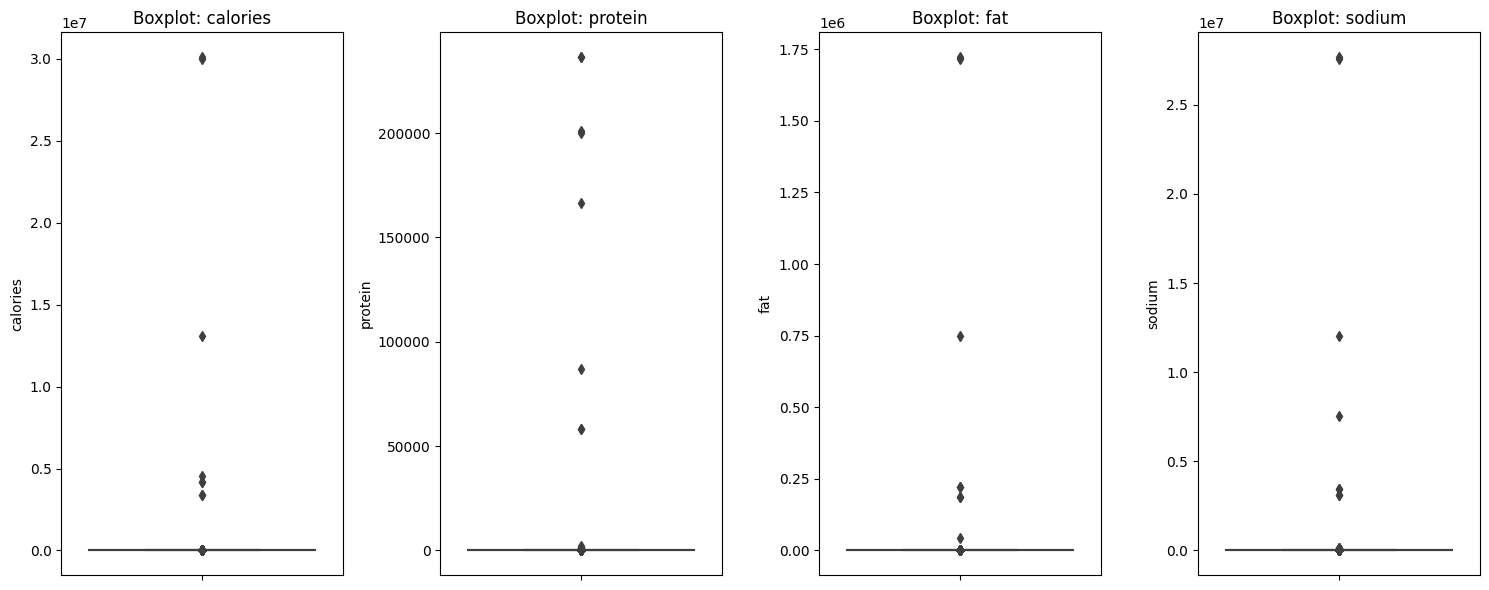

In [24]:
current_columns = important_column[2:]
output_boxplots(current_columns)

In [25]:
df, clean_info = iqr_cleaner(df, current_columns)
clean_info

,колонка,выбросы_до,выбросы_после,очищено,нижняя_граница,верхняя_граница,мин_до,макс_до,мин_после,макс_после,Q1,Q3,IQR
0,calories,440,0,440,-966.0,1750.0,0.0,30111218.0,0.0,1750.0,198.0,586.0,388.0
1,protein,440,0,440,-69.0,99.0,0.0,236489.0,0.0,99.0,3.0,27.0,24.0
2,fat,452,0,452,-71.0,111.0,0.0,1722763.0,0.0,111.0,7.0,33.0,26.0
3,sodium,527,0,527,-1813.0,2604.0,0.0,27675110.0,0.0,2604.0,80.0,711.0,631.0


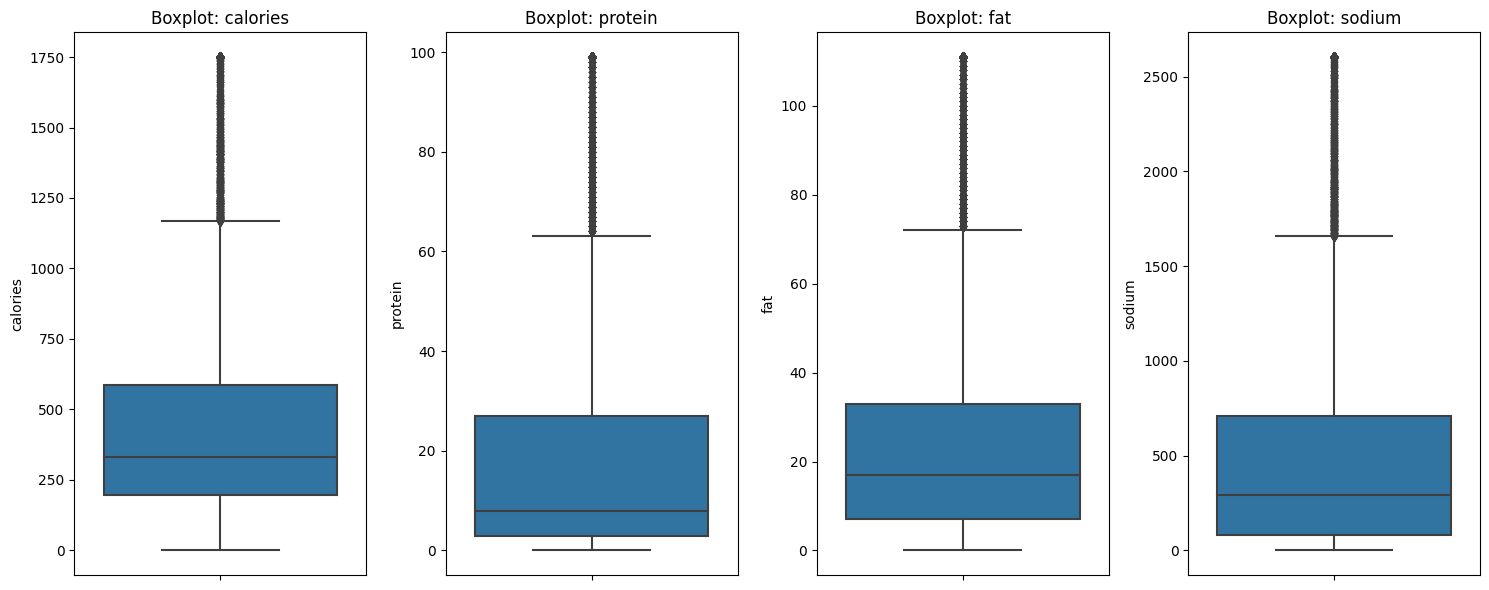

In [26]:
output_boxplots(current_columns)

In [27]:
df.describe()

,rating,calories,protein,fat,sodium,3-ingredient recipes,alcoholic,almond,amaretto,anchovy,...,wasabi,watercress,watermelon,whiskey,white wine,whole wheat,wine,yogurt,zucchini,turkey
count,20052.000000,15935.000000,15890.000000,15869.000000,15933.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,452.400628,18.892133,25.200076,524.702944,0.001346,0.041642,0.029124,0.001945,0.002244,...,0.001147,0.006882,0.003591,0.002843,0.024287,0.001496,0.009525,0.026332,0.014861,0.022741
std,1.340829,381.222114,23.851742,25.771489,630.339385,0.036671,0.199774,0.168159,0.044060,0.047321,...,0.033849,0.082675,0.059816,0.053242,0.153942,0.038652,0.097134,0.160123,0.121001,0.149080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,198.000000,3.000000,7.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,331.000000,8.000000,17.000000,294.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,586.000000,27.000000,33.000000,711.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,1750.000000,99.000000,111.000000,2604.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Шаг 3. Подготовка моделей машинного обучения

### Фун-ии для этого шага

In [28]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Mean Actual': y_test.mean(),
        'Mean Predicted': y_pred.mean()
    }

    print(f"\n=== {model_name} ===")
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')

    return metrics

In [29]:
def train_all_models(models, X_train, X_test, y_train, y_test): 
    
    results = {} 
    best_models = {} 
    
    for model_config in tqdm(models, desc='Training models'): 
        name = model_config['name']
        print(f'Training {name}')
        
        grid_search = GridSearchCV(
            estimator=model_config['pipeline'], 
            param_grid=model_config['params'], 
            cv=5, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        best_models[name] = grid_search.best_estimator_ 
        
        y_pred = grid_search.predict(X_test) 
        
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)), 
            'MAE': mean_absolute_error(y_test, y_pred), 
            'R2': r2_score(y_test, y_pred),
            'CV_RMSE': np.sqrt(-grid_search.best_score_),
            'Best_Params': grid_search.best_params_
        }
        
        results[name] = metrics 
        
        
        print(f"Best CV Score (RMSE): {metrics['CV_RMSE']:.4f}")
        print(f"Test RMSE: {metrics['RMSE']:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")
        print() 
        print()
        
    return results, best_models    

### Проверяю, что пропусков в целевой переменной нет

In [30]:
df['rating'].isna().sum()

0

### Разделяю на тестовую и тренировочную выборку

In [31]:
df = df.fillna(0)
df[important_column].head(3)

,title,rating,calories,protein,fat,sodium
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0


In [32]:
target = df['rating']
features = df.drop(['title', 'rating'], axis=1)
len(features.columns.tolist()), len(set(features.columns.tolist()))

(298, 298)

In [33]:
temp = Counter(features.columns.tolist())
for el, count in temp.items():
    if count == 2:
        print(el, count)

In [34]:
features = features.loc[:, ~features.columns.duplicated()]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=21)

In [36]:
y_train = np.round(y_train).astype(int)
y_test = np.round(y_test).astype(int)

### Тестирование различных регрессионных моделей

In [37]:
num_features = ['calories', 'protein', 'fat', 'sodium']
binary_features = [el for el in features.columns if el not in num_features]

preprocess = ColumnTransformer(
    [
        ('num', StandardScaler(), num_features),
        ('bin', 'passthrough', binary_features)
    ]
)

In [336]:
### смотрю пример как выглядят масштабированные данные
X_train_transformed = preprocess.fit_transform(X_train)

In [337]:
# lin_pipeline = {
#     'name': 'LinearRegression',
#     'pipeline': Pipeline([
#         ('preprocess', preprocess),
#         ('model', LinearRegression())
#     ]),
#     'params': {}
# }

# ridge_pipeline = {
#     'name': 'Ridge',
#     'pipeline': Pipeline([
#         ('preprocess', preprocess),
#         ('model', Ridge(random_state=21))
#     ]),
#     'params': {
#         'model__alpha': [0.1, 1.0, 10.0, 30.0, 50.0, 70.0, 100.0]
#     }
# }

# lasso_pipeline = {
#     'name': 'Lasso',
#     'pipeline': Pipeline([
#         ('preprocess', preprocess),
#         ('model', Lasso(random_state=21))
#     ]),
#     'params': {
#         'model__alpha': [0.001, 0.01, 0.1, 1.0]
#     }
# }

# tree_pipeline = {
#     'name': 'DecisionTreeRegressor',
#     'pipeline': Pipeline([
#         ('preprocess', preprocess),
#         ('model', DecisionTreeRegressor(random_state=21))
#     ]),
#     'params': {
#         'model__max_depth': [None, 10, 20, 30],
#         'model__min_samples_split': [2, 5, 10]
#     }
# }

# forest_pipeline = {
#     'name': 'RandomForestRegressor',
#     'pipeline': Pipeline([
#         ('preprocess', preprocess),
#         ('model', RandomForestRegressor(random_state=21, n_jobs=-1))
#     ]),
#     'params': {
#         'model__n_estimators': [50, 70, 90, 100],
#         'model__max_depth': [None, 10, 20],
#         'model__min_samples_split': [2, 4, 6]
#     }
# }

In [338]:
lin_one_model_pipeline = {
    'name': 'LinearRegression',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', LinearRegression())
    ]),
    'params': {}
}

ridge_one_model_pipeline = {
    'name': 'Ridge',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', Ridge(random_state=21))
    ]),
    'params': {
        'model__alpha': [50.0]
    }
}

lasso_one_model_pipeline = {
    'name': 'Lasso',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', Lasso(random_state=21))
    ]),
    'params': {
        'model__alpha': [0.001]
    }
}

tree_one_model_pipeline = {
    'name': 'DecisionTreeRegressor',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', DecisionTreeRegressor(random_state=21))
    ]),
    'params': {
        'model__max_depth': [10],
        'model__min_samples_split': [10]
    }
}

forest_one_model_pipeline = {
    'name': 'RandomForestRegressor',
    'pipeline': Pipeline([
        ('preprocess', preprocess),
        ('model', RandomForestRegressor(random_state=21, n_jobs=-1))
    ]),
    'params': {
        'model__n_estimators': [100],
        'model__max_depth': [None],
        'model__min_samples_split': [6]
    }
}

In [339]:
models = [lin_one_model_pipeline, ridge_one_model_pipeline, lasso_one_model_pipeline, tree_one_model_pipeline, forest_one_model_pipeline]

In [340]:
results, best_models = train_all_models(models, X_train, X_test, y_train, y_test)

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training LinearRegression
Best CV Score (RMSE): 1.2529
Test RMSE: 1.2256
Best parameters: {}


Training Ridge
Best CV Score (RMSE): 1.2471
Test RMSE: 1.2242
Best parameters: {'model__alpha': 50.0}


Training Lasso
Best CV Score (RMSE): 1.2480
Test RMSE: 1.2261
Best parameters: {'model__alpha': 0.001}


Training DecisionTreeRegressor
Best CV Score (RMSE): 1.2862
Test RMSE: 1.2604
Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10}


Training RandomForestRegressor
Best CV Score (RMSE): 1.2248
Test RMSE: 1.1696
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 6, 'model__n_estimators': 100}




### Сохранение RandomForestRegressor

In [38]:
naive_pred = np.full_like(y_test, y_train.mean())
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
naive_rmse

1.4215108490586779

In [351]:
output_features = X_test.columns.tolist()

In [352]:
joblib.dump({'model': best_models['RandomForestRegressor'], 'features_column': output_features}, '../final_models/random_forest_regressor.pkl')

['../final_models/random_forest_regressor.pkl']

# Сохранение очищенного фрейма для следующего шага

In [353]:
# df.shape

In [354]:
# df.to_csv('data/clean_epi_r.csv', index=False)